In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
from sklearn.preprocessing import MinMaxScaler,quantile_transform,StandardScaler

In [3]:
df_confirm = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_confirm = df_confirm.groupby('Country/Region').sum().drop(['Lat','Long'],axis=1)
df_confirm.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,54403,54483,54559,54595,54672,54750,54854,54891,54939,55008
Albania,0,0,0,0,0,0,0,0,0,0,...,69916,70655,71441,72274,72812,73691,74567,75454,76350,77251
Algeria,0,0,0,0,0,0,0,0,0,0,...,104852,105124,105369,105596,105854,106097,106359,106610,106887,107122
Andorra,0,0,0,0,0,0,0,0,0,0,...,9379,9416,9499,9549,9596,9638,9716,9779,9837,9885
Angola,0,0,0,0,0,0,0,0,0,0,...,19177,19269,19367,19399,19476,19553,19580,19672,19723,19782


In [4]:
# data clean and index seting
df_trans = df_confirm.transpose()
df_trans['World'] = df_trans.sum(axis =1)
df_confirm = df_trans.set_index(pd.DatetimeIndex(pd.to_datetime(df_trans.index.values,format="%m/%d/%y")))
df_confirm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 375 entries, 2020-01-22 to 2021-01-30
Columns: 193 entries, Afghanistan to World
dtypes: int64(193)
memory usage: 568.4 KB


In [5]:
COUNTIRES = df_confirm.columns.to_list()

num_features = len(df_confirm.columns)
num_features

country2id = {}
for i,name in enumerate(COUNTIRES):
    country2id[name]= i

## Data Transformation

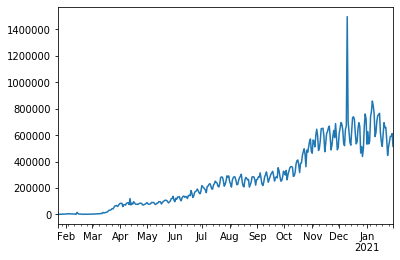

In [6]:
df = df_confirm.diff().dropna()
df['World'].plot(kind = 'line')

In [7]:
# using past # of INPUT points to predict future # of PRED points
INPUT = 30
PRED = 30
SHIFT = 0
BATCH =32
WINDOW =INPUT+PRED+SHIFT

# slice for training data, leave one ts set for validation
df_train = df[:-PRED]
df_test = df[-WINDOW:]
#df_train =df

In [8]:
cs = MinMaxScaler()
train = cs.fit_transform(df_train)
test= cs.transform(df_test)

### Train set split

In [9]:
# get random series of train+target
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=train,
      targets=None,
      sequence_length=WINDOW,
      sequence_stride=1,
      shuffle=True,
      seed=42,
      batch_size=BATCH)


In [10]:
# ds will be varied when it was called
trainingset = tf.concat([i for i in ds], axis=0)
val_len = int(trainingset.shape[0]*0.2)
X_train = trainingset[:-val_len,:INPUT,:]
y_train = trainingset[:-val_len,INPUT:,:]
X_val = trainingset[-val_len:,:INPUT,:]
y_val = trainingset[-val_len:,INPUT:,:]

In [11]:
trainingset[0,:,-1]

<tf.Tensor: shape=(60,), dtype=float64, numpy=
array([0.00429457, 0.00136606, 0.00139278, 0.00129392, 0.00119171,
       0.00026854, 0.00030862, 0.00035471, 0.00111088, 0.00018838,
       0.00031129, 0.00050434, 0.00058717, 0.00084302, 0.00086105,
       0.00119706, 0.00152504, 0.00125918, 0.00166733, 0.00147628,
       0.00181228, 0.00254842, 0.00266999, 0.00257247, 0.00272143,
       0.00315563, 0.00505208, 0.00380225, 0.00954438, 0.00733196,
       0.00746289, 0.00982761, 0.01058512, 0.01299927, 0.01800326,
       0.02049356, 0.02131253, 0.02323035, 0.02856099, 0.02743675,
       0.03401855, 0.0419163 , 0.04340193, 0.0448702 , 0.03952286,
       0.04354088, 0.0512683 , 0.05523955, 0.05542125, 0.05574323,
       0.03895373, 0.04843064, 0.04879269, 0.04658295, 0.05561163,
       0.0580672 , 0.05707589, 0.04957225, 0.07989074, 0.04717747])>

In [12]:
X_train[0,:,-1]

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([0.00429457, 0.00136606, 0.00139278, 0.00129392, 0.00119171,
       0.00026854, 0.00030862, 0.00035471, 0.00111088, 0.00018838,
       0.00031129, 0.00050434, 0.00058717, 0.00084302, 0.00086105,
       0.00119706, 0.00152504, 0.00125918, 0.00166733, 0.00147628,
       0.00181228, 0.00254842, 0.00266999, 0.00257247, 0.00272143,
       0.00315563, 0.00505208, 0.00380225, 0.00954438, 0.00733196])>

In [13]:
y_train[0,:,-1]

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([0.00746289, 0.00982761, 0.01058512, 0.01299927, 0.01800326,
       0.02049356, 0.02131253, 0.02323035, 0.02856099, 0.02743675,
       0.03401855, 0.0419163 , 0.04340193, 0.0448702 , 0.03952286,
       0.04354088, 0.0512683 , 0.05523955, 0.05542125, 0.05574323,
       0.03895373, 0.04843064, 0.04879269, 0.04658295, 0.05561163,
       0.0580672 , 0.05707589, 0.04957225, 0.07989074, 0.04717747])>

### Test set split

In [14]:
X_test = test[-WINDOW:-PRED]
y_test = test[-PRED:]
# reshape from [step,feature] to [batch, step,feature]
X_test = tf.expand_dims(X_test,axis=0)
y_test = tf.expand_dims(y_test,axis=0)

In [15]:
dataset={
    'X_train':X_train,
    'y_train':y_train,
    'X_val':X_val,
    'y_val':y_val,
    'X_test':X_test,
    'y_test':y_test
}

In [16]:
# dataset={
#     'X_train':X_train[:,:,-1:],
#     'y_train':y_train[:,:,-1:],
#     'X_val':X_val[:,:,-1:],
#     'y_val':y_val[:,:,-1:],
#     'X_test':X_test[:,:,-1:],
#     'y_test':y_test[:,:,-1:],
# }
# num_features=1

### Models

In [17]:
def compile_and_fit(model, dataset = dataset, patience=2, epochs = 20,batch_size=32,verbose=2):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            verbose=verbose,  patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(dataset['X_train'],dataset['y_train'], epochs=epochs,
                      validation_data=(dataset['X_val'],dataset['y_val']),
                      callbacks=[early_stopping],verbose=verbose,batch_size=batch_size)
    return history

In [18]:
tf.keras.backend.set_floatx('float64')

In [19]:
# draw results
def draw_pred(model,dataset,country2id,country_name,pred=PRED):
    country_id = country2id[country_name]
    ts_mse = model.evaluate(dataset['X_test'],dataset['y_test'])[0]
    y_pred = model.predict(dataset['X_test'])
    if pred ==1:
        sns.barplot(x=['Pred','Real'],y=[y_test.numpy().squeeze()[country_id],y_pred.squeeze()[country_id]])
        plt.title('Test_MSE: {:.2f}'.format(ts_mse))
    else:
        axes = sns.lineplot(x=range(pred),y=y_pred.squeeze()[:,country_id].cumsum(),label='Pred (test_MSE:{:.2f})'.format(ts_mse))
        sns.lineplot(x=range(pred),y=y_test.numpy().squeeze()[:,country_id].cumsum(),ax=axes,label='Real')
    

### Naive

In [20]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, PRED, 1])

last_baseline = MultiStepLastBaseline()
history = compile_and_fit(last_baseline,dataset,verbose=2)

Epoch 1/20
8/8 - 0s - loss: 0.0217 - mean_absolute_error: 0.0735 - val_loss: 0.0201 - val_mean_absolute_error: 0.0693
Epoch 2/20
8/8 - 0s - loss: 0.0217 - mean_absolute_error: 0.0735 - val_loss: 0.0201 - val_mean_absolute_error: 0.0693
Epoch 3/20
8/8 - 0s - loss: 0.0217 - mean_absolute_error: 0.0735 - val_loss: 0.0201 - val_mean_absolute_error: 0.0693
Epoch 00003: early stopping


In [21]:
class MultiStepRepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = MultiStepRepeatBaseline()
history = compile_and_fit(repeat_baseline,dataset,verbose=2)

Epoch 1/20
8/8 - 0s - loss: 0.0319 - mean_absolute_error: 0.0949 - val_loss: 0.0294 - val_mean_absolute_error: 0.0893
Epoch 2/20
8/8 - 0s - loss: 0.0319 - mean_absolute_error: 0.0949 - val_loss: 0.0294 - val_mean_absolute_error: 0.0893
Epoch 3/20
8/8 - 0s - loss: 0.0319 - mean_absolute_error: 0.0949 - val_loss: 0.0294 - val_mean_absolute_error: 0.0893
Epoch 00003: early stopping


### Linear 

In [22]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    #tf.keras.layers.Flatten(input_shape=[INPUT,num_features]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(PRED*num_features),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([PRED, num_features])
    
])
history = compile_and_fit(multi_linear_model, dataset,epochs=500,verbose=0)

### Dense

In [23]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Flatten(input_shape=[INPUT,num_features]),
    #tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal"),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(PRED*num_features,
                          activation='relu',kernel_initializer="he_normal"),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([PRED, num_features])
])

history = compile_and_fit(multi_dense_model, dataset,epochs=500,verbose=2)


Epoch 1/500
8/8 - 0s - loss: 0.0588 - mean_absolute_error: 0.1510 - val_loss: 0.0459 - val_mean_absolute_error: 0.1289
Epoch 2/500
8/8 - 0s - loss: 0.0479 - mean_absolute_error: 0.1332 - val_loss: 0.0381 - val_mean_absolute_error: 0.1181
Epoch 3/500
8/8 - 0s - loss: 0.0396 - mean_absolute_error: 0.1193 - val_loss: 0.0318 - val_mean_absolute_error: 0.1036
Epoch 4/500
8/8 - 0s - loss: 0.0324 - mean_absolute_error: 0.1056 - val_loss: 0.0270 - val_mean_absolute_error: 0.0959
Epoch 5/500
8/8 - 0s - loss: 0.0277 - mean_absolute_error: 0.0964 - val_loss: 0.0236 - val_mean_absolute_error: 0.0873
Epoch 6/500
8/8 - 0s - loss: 0.0243 - mean_absolute_error: 0.0889 - val_loss: 0.0219 - val_mean_absolute_error: 0.0835
Epoch 7/500
8/8 - 0s - loss: 0.0242 - mean_absolute_error: 0.0894 - val_loss: 0.0203 - val_mean_absolute_error: 0.0813
Epoch 8/500
8/8 - 0s - loss: 0.0221 - mean_absolute_error: 0.0839 - val_loss: 0.0194 - val_mean_absolute_error: 0.0768
Epoch 9/500
8/8 - 0s - loss: 0.0207 - mean_absol

### CNN

In [24]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    #tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units] 
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH),input_shape=(INPUT,num_features)),
    #tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(PRED*num_features),
    
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([PRED, num_features])
])

history = compile_and_fit(multi_conv_model, dataset,epochs=500,verbose=0)


In [25]:
multi_rnn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.SimpleRNN(128,return_sequences=False,input_shape = (INPUT, num_features)),
    # Shape => [batch, out_steps*features]
#      tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_features,
#                            kernel_initializer=tf.initializers.zeros)),
    tf.keras.layers.Dense(PRED*num_features),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([PRED, num_features])
])

history = compile_and_fit(multi_rnn_model, dataset,epochs=500,verbose=0)

In [26]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64,return_sequences=False,input_shape = (INPUT, num_features)),
    #tf.keras.layers.LSTM(32,return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(PRED*num_features),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([PRED, num_features])
])

history = compile_and_fit(multi_lstm_model, dataset,epochs=500,verbose=0)

In [27]:
model_val_performance = {}
model_test_performance ={}
models = {'Naive_1':last_baseline,
          'Naive_2':repeat_baseline,
          'Linear':multi_linear_model,
          'Dense':multi_dense_model,
          'Conv':multi_conv_model,
          'RNN':multi_rnn_model,
          'LSTM':multi_lstm_model
         }
for k,v in models.items():
    
    model_val_performance[k] = v.evaluate(dataset['X_val'],dataset['y_val'],verbose=0)
    model_test_performance[k] = v.evaluate(dataset['X_train'],dataset['y_train'],verbose=0)

In [28]:
list(model_val_performance.keys())

['Naive_1', 'Naive_2', 'Linear', 'Dense', 'Conv', 'RNN', 'LSTM']

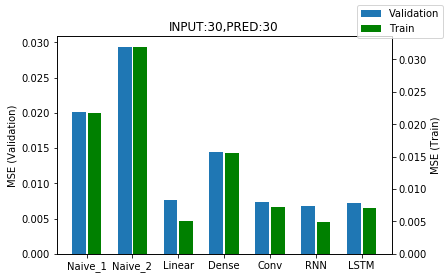

In [29]:
x = np.arange(len(model_val_performance))
width = 0.3

metric_name = 'mean_squared_error'
val_mse = [v[0] for v in model_val_performance.values()]
test_mse = [v[0] for v in model_test_performance.values()]

fig,ax = plt.subplots()
l1 = ax.bar(x - 0.17, val_mse, width, label='Validation')
ax2 = ax.twinx()
l2 = ax2.bar(x + 0.17, test_mse, width, label='Train',color='g')
plt.xticks(ticks=x, labels=model_val_performance.keys(),
           rotation=45)
ax.set_ylabel(f'MSE (Validation)')
ax2.set_ylabel(f'MSE (Train)')

# added these three lines
fig.legend(loc="upper right")
plt.title('INPUT:{},PRED:{}'.format(INPUT,PRED))
plt.savefig('INPUT:{},PRED:{}.png'.format(INPUT,PRED))
fig.savefig("_images/models_comparsion.png")

In [30]:
val_mse

[0.020105038066966494,
 0.029378699890354222,
 0.00771021508007196,
 0.014393669896219907,
 0.0073412465454455005,
 0.006863418451853488,
 0.007282135942787455]

In [31]:
# draw results
def draw_pred(model,dataset,country2id,country_name,pred=PRED):
    country_id = country2id[country_name]
    ts_mse = model.evaluate(dataset['X_test'],dataset['y_test'])[0]
    #y_pred = model.predict(dataset['X_test'])
    mc_result =np.stack([model(dataset['X_test'],training =True).numpy() for sample in range(100)])
    y_pred = mc_result.mean(axis=0)
    fig,ax = plt.subplots()
    if pred ==1:
        sns.barplot(x=['Pred','Real'],y=[y_test.numpy().squeeze()[country_id],y_pred.squeeze()[country_id]])
        plt.title('Test_MSE: {:.2f}'.format(ts_mse))
    else:
        axes = sns.lineplot(x=range(pred),y=y_pred.squeeze()[:,country_id].cumsum(),label='Pred (test_MSE:{:.2f})'.format(ts_mse))
        sns.lineplot(x=range(pred),y=y_test.numpy().squeeze()[:,country_id].cumsum(),ax=axes,label='Real')
    plt.xlabel("Predicted Days")
    plt.ylabel("Cases(standarized)")
    plt.title("{}'s trend chart".format(country_name))
    plt.show()
    fig.savefig("_images/{}_trend.png".format(country_name))

1/1 [==============================] - 0s 1ms/step - loss: 0.5105 - mean_absolute_error: 0.3207


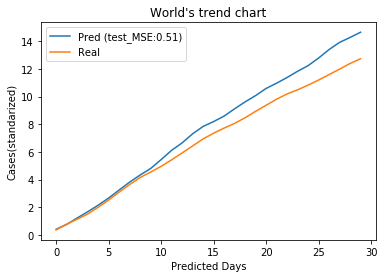

In [32]:
draw_pred(multi_linear_model,dataset,country2id,'World')

1/1 [==============================] - 0s 956us/step - loss: 0.5032 - mean_absolute_error: 0.2907


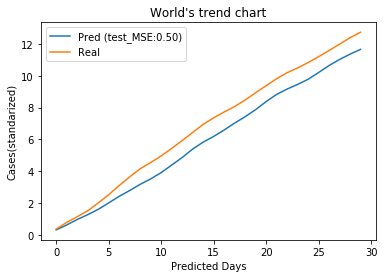

In [33]:
draw_pred(multi_rnn_model,dataset,country2id,'World')

1/1 [==============================] - 0s 2ms/step - loss: 0.5123 - mean_absolute_error: 0.2963


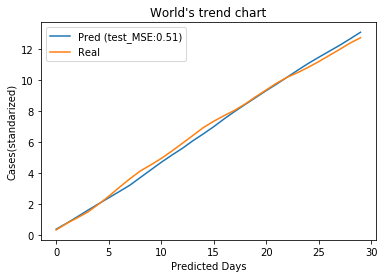

In [41]:
draw_pred(multi_lstm_model,dataset,country2id,'World')

1/1 [==============================] - 0s 992us/step - loss: 0.5031 - mean_absolute_error: 0.2870


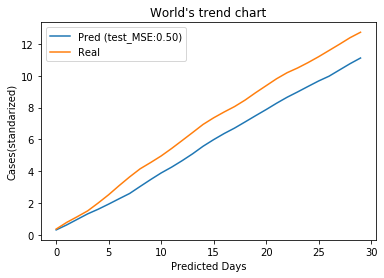

In [35]:
draw_pred(multi_conv_model,dataset,country2id,'World')

In [36]:
def draw_daily(model,dataset,country2id,country_name,pred=PRED):
    country_id = country2id[country_name]
    ts_mse = model.evaluate(dataset['X_test'],dataset['y_test'])[0]
    y_pred = model.predict(dataset['X_test'])
    fig,ax = plt.subplots()
    if pred ==1:
        sns.barplot(x=['Pred','Real'],y=[y_test.numpy().squeeze()[country_id],y_pred.squeeze()[country_id]])
        plt.title('Test_MSE: {:.2f}'.format(ts_mse))
    else:
        axes = sns.lineplot(x=range(pred),y=y_pred.squeeze()[:,country_id],label='Pred (test_MSE:{:.2f})'.format(ts_mse))
        sns.lineplot(x=range(pred),y=y_test.numpy().squeeze()[:,country_id],ax=axes,label='Real')
    plt.xlabel("Predicted Days")
    plt.ylabel("Daily Cases(standarized)")
    plt.title("{}'s trend chart".format(country_name))
    plt.show()
    fig.savefig("_images/{}_daily.png".format(country_name))

1/1 [==============================] - 0s 1ms/step - loss: 0.5031 - mean_absolute_error: 0.2870


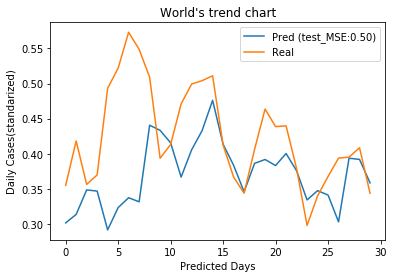

In [37]:
draw_daily(multi_conv_model,dataset,country2id,'World')

1/1 [==============================] - 0s 817us/step - loss: 0.5105 - mean_absolute_error: 0.3207


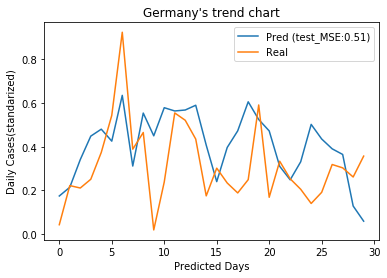

In [38]:
draw_daily(multi_linear_model,dataset,country2id,'Germany')

1/1 [==============================] - 0s 953us/step - loss: 0.5032 - mean_absolute_error: 0.2907


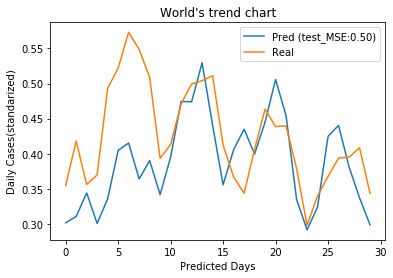

In [39]:
draw_daily(multi_rnn_model,dataset,country2id,'World')

1/1 [==============================] - 0s 986us/step - loss: 0.5123 - mean_absolute_error: 0.2963


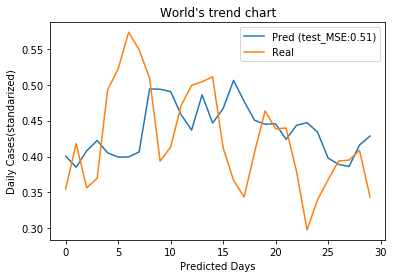

In [42]:
draw_daily(multi_lstm_model,dataset,country2id,'World')

### Save models

In [41]:
# for k,v in models.items():
#     v.save('{}_model'.format(k),save_format="tf")

SyntaxError: EOL while scanning string literal (<ipython-input-41-5bed24185270>, line 2)

### Save Scaler

In [ ]:
# with open('scaler.pkl','wb') as f:
#     pickle.dump(cs,f)

### Load models

In [ ]:
#load_rnn = tf.keras.models.load_model("model_confirm_case/RNN_model")
load_rnn = tf.keras.models.load_model("rnn_model.h5")

In [43]:
def get_pred(model,input_step,country_id):
    mc_result =np.stack([model(input_step,training =True).numpy() for sample in range(100)])
    pred = cs.inverse_transform(mc_result.mean(axis=0).squeeze())
    return pred[:,_id]

### Inverse to origin data format

In [44]:
from sklearn.metrics import mean_squared_error

In [45]:
mc_result =np.stack([multi_rnn_model(dataset['X_test'],training =True).numpy() for sample in range(100)])
pred = cs.inverse_transform(mc_result.mean(axis=0).squeeze())


In [46]:
LAST_DATE = df_train.index[-1]
LAST_DATE

Timestamp('2020-12-31 00:00:00')

In [47]:
index = pd.date_range(start=LAST_DATE+dt.timedelta(days=1), periods=PRED)
index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30'],
              dtype='datetime64[ns]', freq='D')

In [48]:
df_pred = pd.DataFrame(pred,index=index,columns=df_confirm.columns.tolist()).cumsum()

In [49]:
df_confirm[-PRED-1:].index[0]

Timestamp('2020-12-31 00:00:00')

In [50]:
def get_mse (model,dataset,country2id,country_name,PRED=PRED):
     # get verage of 100 predictions
    mc_result =np.stack([model(dataset['X_test'],training =True).numpy() for sample in range(100)])
    pred = cs.inverse_transform(mc_result.mean(axis=0).squeeze())
    _id = country2id[country_name]
    _pred = pred[:,_id]
    _actual = df_test[-PRED:][country_name]
    return mean_squared_error(_actual,_pred)

In [51]:
import pickle

In [52]:
with open('arima_result.pkl','rb') as f:
    arima_mse = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'arima_result.pkl'

In [ ]:
linear_mse={}
dense_mse={}
cnn_mse={}
rnn_mse={}
lstm_mse={}
for c in arima_mse.keys():
        linear_mse[c] = get_mse(multi_linear_model,dataset,country2id,c)
        dense_mse[c] = get_mse(multi_dense_model,dataset,country2id,c)
        cnn_mse[c] = get_mse(multi_conv_model,dataset,country2id,c)
        rnn_mse[c] = get_mse(multi_rnn_model,dataset,country2id,c)
        lstm_mse[c] = get_mse(multi_lstm_model,dataset,country2id,c)
    
    

In [3240]:
result = pd.DataFrame.from_dict(arima_mse,orient='index',columns=['ARIMA'])

In [3241]:
result['Linear'] = linear_mse.values()
result['Dense'] = dense_mse.values()
result['Conv'] = cnn_mse.values()
result['RNN'] = rnn_mse.values()
result['LSTM'] = lstm_mse.values()

In [3242]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [3243]:
result = result.apply(np.sqrt)

In [3244]:
result.style.apply(highlight_min,axis=1)

,ARIMA,Linear,Dense,Conv,RNN,LSTM
World,295141,138066,249438,138118,134173,115450
US,820338,66477.5,67576.4,60430.3,72538,48859.6
India,26247.2,48516.3,32059.7,20212,32144.4,16700.9
Brazil,57488.3,18234.4,22021.7,18136.8,18266.2,20153.6
Russia,68747.4,3988.39,5808.55,3047.55,5362.41,4539.63
United Kingdom,147838,36256.5,37583.6,35191.7,35095.9,32463.3
France,19911.6,22703.8,20567.4,12320.9,16290.1,13112.1
Spain,166111,26631.4,26110.9,26101.4,26271.8,25948.1
Italy,14534.7,4978.55,8909.17,6400.56,4829.11,7280.41
Turkey,16530.9,76007,15472.7,64480.1,83859.3,65263.4
